In [30]:
# %reload_ext signature
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import PixelArrays
import Grayscale as gray

In [36]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        # B = (min_row, min_col, max_row, max_col)
        if B[3]<col_size and B[2]<row_size and B[0]>0 and B[1]>0:
            good_labels.append(prop.label)
        # To było wcześniej:
#         if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
#             good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0
    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    # Oryginal mask
    mask1 = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    # Improved due to covid changes
    mask2 = morphology.area_closing(mask1, connectivity=2)

    if (display):
        fig, ax = plt.subplots(4, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask1*img, cmap='gray')
        ax[2, 1].axis('off')
        ax[3, 0].set_title("Final second Mask")
        ax[3, 0].imshow(mask2, cmap='gray')
        ax[3, 0].axis('off')
        ax[3, 1].set_title("Apply Mask on Original")
        ax[3, 1].imshow(mask2*img, cmap='gray')
        ax[3, 1].axis('off')
        
        
        plt.show()
    return mask2*img

# Dicom Images

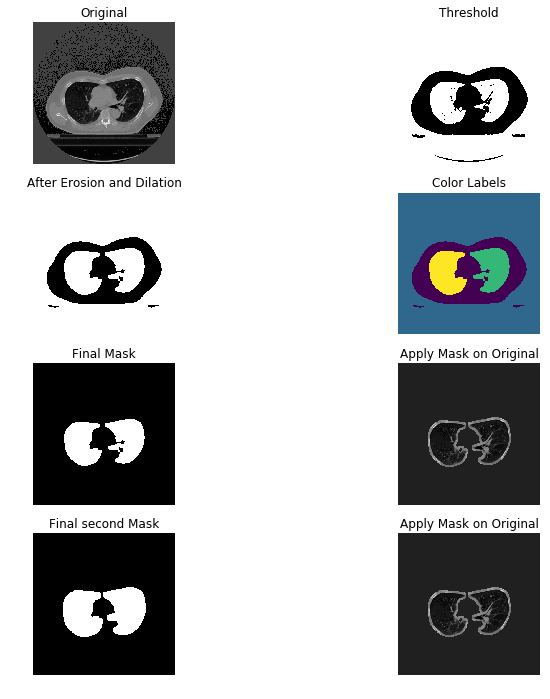

In [37]:
# medical_image = pydicom.dcmread(r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent2_dcm\1-067.dcm")
image = gray.get_grayscale_from_dicom("1-067.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent2_dcm")
mask = make_lungmask(image, True)

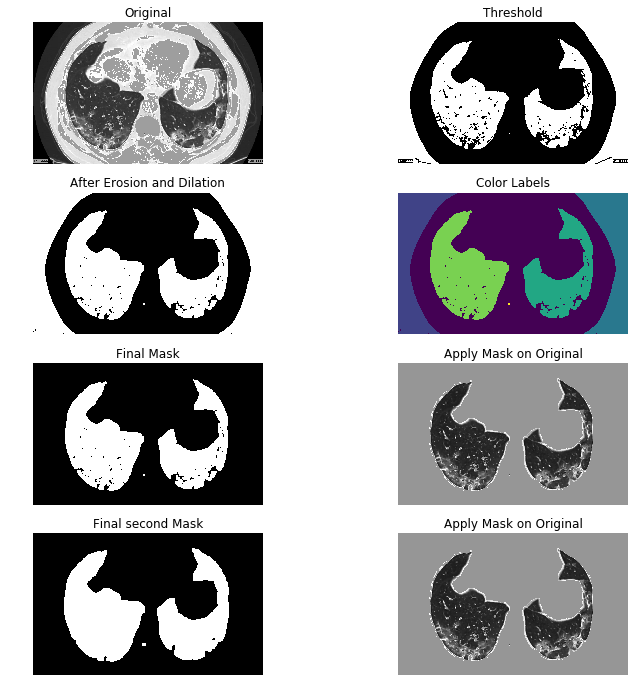

In [33]:
image = gray.get_grayscale_from_dicom("Italy_case010060.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent_dcm")
mask = make_lungmask(image, True)

# JPG & PNG Images

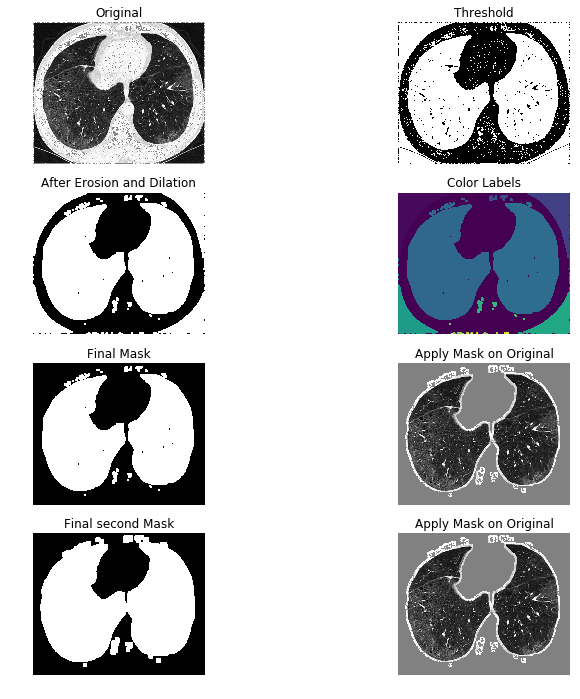

In [23]:
image = gray.get_grayscale_from_jpg_png("covid5.jpg", r"D:\Studia\sem7\inzynierka\aplikacja\images_data")
mask = make_lungmask(image, True)

In [38]:
image = gray.get_grayscale_from_jpg_png("covid5.png", r"D:\Studia\sem7\inzynierka\aplikacja\images_data")
# mask = make_lungmask(image, True)
# mpimg.imread( r"D:\Studia\sem7\inzynierka\aplikacja\images_data\covid5.png")
# mpimg.imread(str(r"D:\Studia\sem7\inzynierka\aplikacja\images_data\covid5.png"))

TypeError: Object does not appear to be a 8-bit string path or a Python file-like object

# Nifit Images

In [33]:
medical_image = gray.get_plot_data_nii(r"D:\Studia\sem7\inzynierka\aplikacja\images_data\coronacases_org_001.nii", 50)